In [1]:
import sys
sys.path.append("src")
from qaoa.core.QAOA import QAOArunner
from  qaoa.models.MaxCutProblem import MaxCutProblem
import  qaoa.models.params as params
from rustworkx.visualization import mpl_draw as draw_graph
from old_jupyter_vizualisers.load_data import load_graph_from_csv
import numpy as np

In [2]:
import itertools

settings = {
'backend_mode' : ['noisy_sampling'], #nois_sampling
'qaoa_variant': ['vanilla'],#,'multiangle'
'param_initialization': ['gaussian'],
'depth':[1,4],#MANGLER 10 PÅ MULTIANGLE
'warm_start': [False,True],
'problem_type': ['minvertexcover']
}

keys = settings.keys()
values = settings.values()

combinations = [dict(zip(keys, combination)) for combination in itertools.product(*values)]
print(f'echo "{combinations}" > qaoa_settings.txt')
#print(len(combinations))

echo "[{'backend_mode': 'noisy_sampling', 'qaoa_variant': 'vanilla', 'param_initialization': 'gaussian', 'depth': 1, 'warm_start': False, 'problem_type': 'minvertexcover'}, {'backend_mode': 'noisy_sampling', 'qaoa_variant': 'vanilla', 'param_initialization': 'gaussian', 'depth': 1, 'warm_start': True, 'problem_type': 'minvertexcover'}, {'backend_mode': 'noisy_sampling', 'qaoa_variant': 'vanilla', 'param_initialization': 'gaussian', 'depth': 4, 'warm_start': False, 'problem_type': 'minvertexcover'}, {'backend_mode': 'noisy_sampling', 'qaoa_variant': 'vanilla', 'param_initialization': 'gaussian', 'depth': 4, 'warm_start': True, 'problem_type': 'minvertexcover'}]" > qaoa_settings.txt


In [3]:
import timeit, numpy as np, collections, random

best_solution      = np.random.randint(0, 2, 50)
feasible_solutions = [np.random.randint(0, 2, 50) for _ in range(100_000)]
hamming_dict       = collections.defaultdict(list)

def loop_version():
    for sol in feasible_solutions:
        h = np.count_nonzero(best_solution != sol)
        hamming_dict[h].append(sol)

def comp_version():
    [
        hamming_dict[np.count_nonzero(best_solution != sol)].append(sol)
        for sol in feasible_solutions
    ]

print("loop :", timeit.timeit(loop_version, number=3))
print("comp :", timeit.timeit(comp_version, number=3))

loop : 0.23155240004416555
comp : 0.3270671999780461


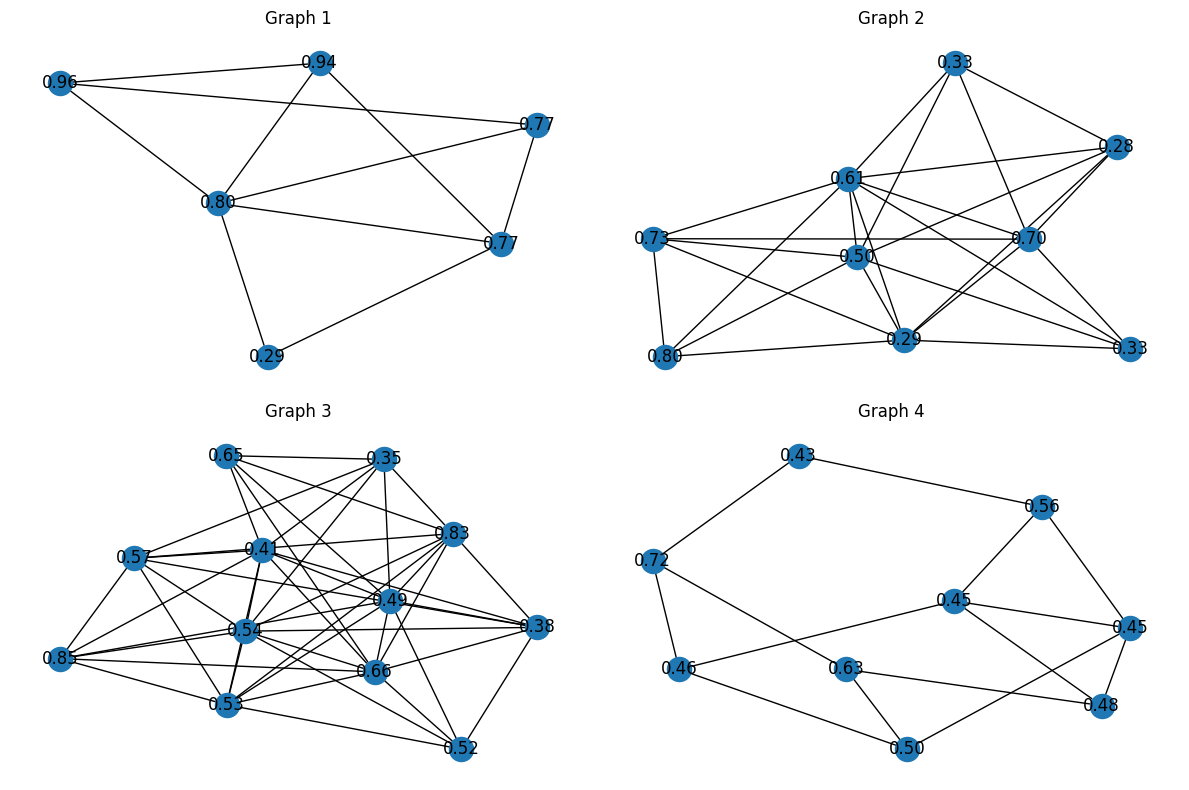

0.7974238714485382
0.7700612176014103
0.956440762925937
0.2947390450335806
0.76789072804424
0.9417981392599122


In [4]:

problem = MaxCutProblem()
graphs = problem.get_erdos_renyi_graphs_paper1()

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2,2, figsize=(12, 8))
axes = axes.flatten()

for idx, graph in enumerate(graphs):
    # Create a mapping from node indices to their values to use as labels
    
    draw_graph(graph, ax=axes[idx], with_labels=True, labels=lambda node: f"{node:.2f}")
    axes[idx].set_title(f"Graph {idx+1}")

plt.tight_layout()
plt.show()
for n in graphs[0].node_indices():
    print(graphs[0][n])

0.797x_0+0.770x_1+0.956x_2+0.295x_3+0.768x_4+0.942x_5
SparsePauliOp(['IIIIZI', 'IIIIIZ', 'IIIZII', 'IIZIII', 'IZIIII', 'ZIIIII', 'IIIIZZ', 'IIIZIZ', 'IIZIIZ', 'IZIIIZ', 'ZIIIIZ', 'IIZIZI', 'IZIIZI', 'ZIIIZI', 'IZIZII', 'ZIIZII'],
              coeffs=[1.61496939+0.j, 2.10128806+0.j, 1.02177962+0.j, 0.85263048+0.j,
 1.11605464+0.j, 1.02910093+0.j, 0.5       +0.j, 0.5       +0.j,
 0.5       +0.j, 0.5       +0.j, 0.5       +0.j, 0.5       +0.j,
 0.5       +0.j, 0.5       +0.j, 0.5       +0.j, 0.5       +0.j])
[1, 1, 0, 0, 1, 1]
None
3.277173956354101
491
[3.92259819 3.9335878  2.50708946 2.36150508 2.34068657 3.72404757
 4.87577434 2.99110465 3.14179084 3.71791944 3.13951273 3.14165252
 3.14358618 4.71113549 5.35941337 3.67683148 0.69948568 0.76122295
 0.93867908 1.57833842 0.80468444 1.56978869]
m 0.49635061483166953


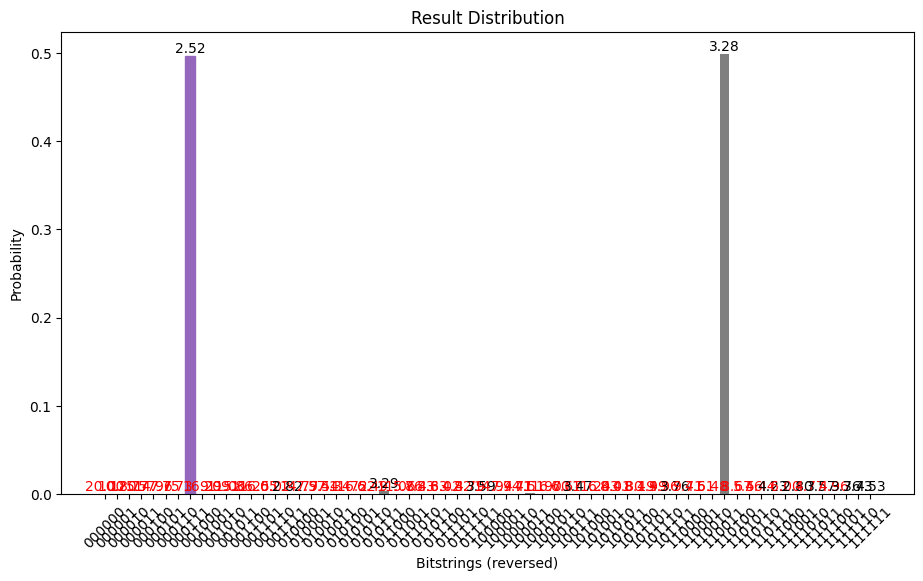

In [9]:
graph = graphs[0]
quantum = QAOArunner(graph=graph, 
                     backend_mode = 'statevector',
                     param_initialization= 'gaussian',
                     qaoa_variant='multiangle', 
                     optimizer='COBYLA',
                     depth =1,
                     problem_type='minvertexcover',
                     warm_start=False,
                     amount_shots = 1000,
                     max_tol = 1e-2,#lower shots and tolerance for faster runs
                     hamming_dist = 1
                     )

quantum.build_circuit()
print(quantum.cost_hamiltonian)
quantum.run()
#print(f'Total time: {quantum.time_elapsed} in which {np.sum(quantum.runtimes)/quantum.time_elapsed:.2f}% was spent inside the cost_func_estimator and {1 - np.sum(quantum.runtimes)/quantum.time_elapsed:.2f} inside optimizer and help functions.')
#removed timer statements from qaoa so above line does not work
print(quantum.solution)
print(quantum.hamming_string)
print(quantum.evaluate_solution())
print(quantum.fev)
print(quantum.final_params)
print('m',quantum.get_prob_measure_optimal())
quantum.print_bitstrings()

<Figure size 640x480 with 0 Axes>

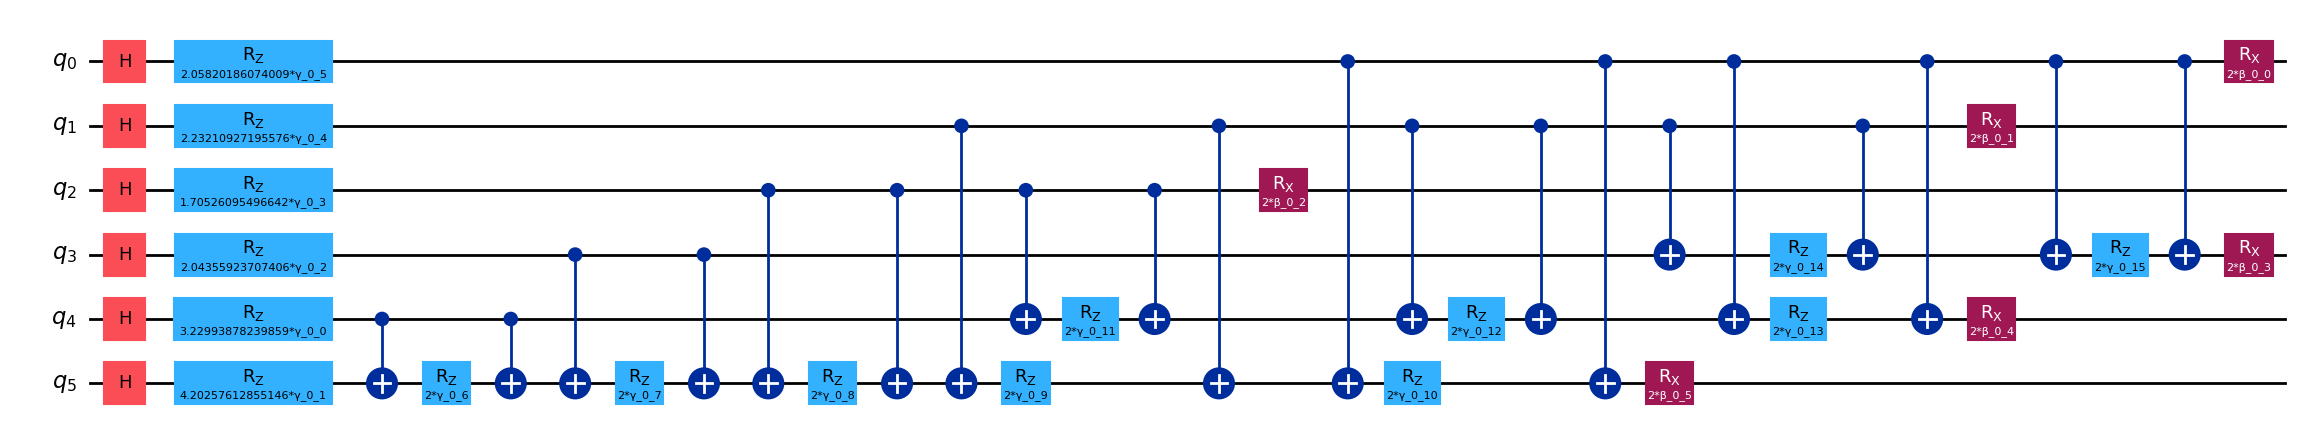

In [6]:
quantum.draw_circuit()

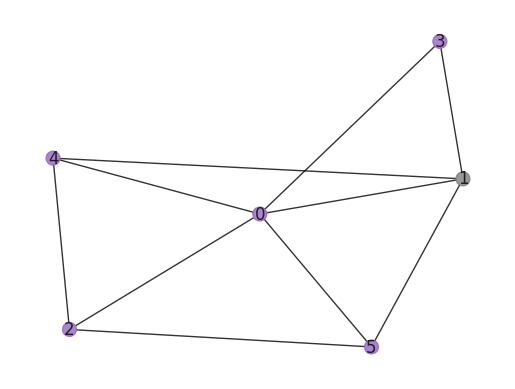

In [7]:
from pprint import pprint

#pprint(quantum.__dict__)
quantum.plot_result()

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from qiskit_ibm_runtime import EstimatorV2 as Estimator
# Define the grid resolution
num_points = 100
gamma_vals = np.linspace(0, 4 * np.pi, num_points)
beta_vals = np.linspace(0,2* np.pi, num_points)
Gamma, Beta = np.meshgrid(gamma_vals, beta_vals)
Z = np.zeros_like(Gamma)



minvertexcover = False

quantum = QAOArunner(graph=graph, 
                     backend_mode='statevector',
                     param_initialization= 'gaussian',
                     qaoa_variant='vanilla', 
                     optimizer='COBYLA',
                     warm_start=False,
                     depth = 1,
                     vertexcover=minvertexcover,
                     amount_shots = 1000,
                     max_tol = 1e-8,
                     lagrangian_multiplier=2
                     )
quantum.build_circuit()
estimator = Estimator(mode=quantum.backend)
estimator.options.default_shots = 5000
# Evaluate cost function at each grid point



for i in tqdm(range(Gamma.shape[0]), desc="Evaluating energy landscape"):
    for j in range(Gamma.shape[1]):
        params = np.array([Gamma[i, j], Beta[i, j]])  # Format your params as needed
        Z[i, j] = quantum.cost_func_estimator(params, quantum.circuit, quantum.cost_hamiltonian,estimator)

# Plot the energy landscape
plt.figure(figsize=(8, 6))
cp = plt.contourf(Gamma, Beta, Z, levels=50)
plt.colorbar(cp, label='Energy')
plt.title("Energy Landscape over [γ, β]")
plt.xlabel("Gamma (γ)")
plt.ylabel("Beta (β)")
plt.show()


TypeError: QAOArunner.__init__() got an unexpected keyword argument 'vertexcover'

In [ ]:
import pandas as pd

# Save Z as a CSV file
df_z = pd.DataFrame({'x': Gamma.ravel(), 'y': Beta.ravel(), 'z': Z.ravel()})
df_z.columns = ['x', 'y', 'z']
df_z.to_csv('percentage_measure_optimal_erdos_renyi_5_2_MaxCut.csv', index=False)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

strin = 'MinVertexCover' if minvertexcover else 'MaxCut'

import plotly.graph_objects as go

fig = go.Figure(data=[go.Surface(z=Z, x=Gamma, y=Beta, colorscale='Viridis')])
fig.update_layout(
    title=f"Percent chance of sampling optimal solution given [γ, β] for Erdos Renyi graph size 5, high prob of edges, for {strin}",
    scene=dict(
        xaxis_title="Gamma (γ)",
        yaxis_title="Beta (β)",
        zaxis_title="Energy"
    )
)
fig.show()

